# Detecting Hateful and Offensive language using NLP

###Connecting Google colab notebook to Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Downloading Helper Functions for model evaluation

In [2]:
! wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-03-05 14:53:31--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-03-05 14:53:31 (63.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import unzip_data, plot_loss_curves, make_confusion_matrix, accuracy_score, calculate_results

###Importing required libraries

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers


In [5]:
df = pd.read_csv("/content/drive/MyDrive/kaggle_datasets/model_ready_combined.csv")

In [6]:
df.head()

,clean training,label
0,as a woman you shouldn t complain about cleani...,0
1,boy dats cold tyga dwn bad for cuffin dat hoe ...,1
2,dawg you ever fuck a bitch and she start to cr...,1
3,she look like a tranny,1
4,the shit you hear about me might be true or it...,1


###Checking number of counts

In [7]:
df['label'].value_counts()

2    56460
1    52371
0    49082
Name: label, dtype: int64

###Converting clean training column to string

In [8]:
df['clean training'] = df['clean training'].apply(str)

###Splitting the text data into training and validation using sklearn train_test_split

In [9]:
from sklearn.model_selection import train_test_split
train_sentences, val_sentences, train_labels, val_labels = train_test_split(df['clean training'].to_list(),
                                                                            df['label'].to_list(),
                                                                            test_size = 0.2,
                                                                            random_state = 42)

###Creating data pipeline to process large data a bit faster while training model

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels))# creating a dataset for faster model training
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels))

In [11]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)# defining batch size
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

## Model Building using Deep Learning

###Automating Feature Engineering process using  pretrained word embeddings model

> Overview of Universal Sentence Encoder (large)

The Universal Sentence Encoder encodes text into high dimensional vectors that can be used for text classification, semantic similarity, clustering and other natural language tasks.

The model is trained and optimized for greater-than-word length text, such as sentences, phrases or short paragraphs. It is trained on a variety of data sources and a variety of tasks with the aim of dynamically accommodating a wide variety of natural language understanding tasks. The input is variable length English text and the output is a 512 dimensional vector. The universal-sentence-encoder-large model is trained with a Transformer encoder.




###Loading Pre trained Universal Sentence Encoder model

In [ ]:
embed = hub.load('https://tfhub.dev/google/universal-sentence-encoder-large/5')

###Creating a sentence encoder layer which we gonna pass through our neural network

In [ ]:
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-large/5", input_shape = [], dtype = "string")

###Building neural network using Functional api


> Functional Api

It is more flexible than the sequential API. It is more powerful than the sequential API in the sense branching or sharing of layers is allowed here. And also it can have multiple inputs and outputs.


> Sequential Api

Here we create the model layer-by-layer. It is very simple and easy to use. But sharing of layers or branching of layers is not allowed. Also, you can’t have multiple inputs or outputs.







In [ ]:
inputs = layers.Input(shape = [], dtype = "string", name = "input_layer") # defining inputs layer
x = sentence_encoder_layer(inputs)# adding sentence encoder layer to network
x = tf.expand_dims(x, axis = 1)# adding one extra dimensison as neural network expects from us if we remove this layer it will pass no an error of dimension
x = layers.Bidirectional(layers.GRU(72, return_sequences = True))(x)# applying Bidirectional Gated Recurrent Unit layer as we are detailing with sequence data we must using RNN
x = layers.BatchNormalization()(x)# This Layer is used to make training of artificial neural networks faster and more stable through normalization of the layers' inputs by re-centering and re-scaling
x = layers.Dropout(0.5)(x)#This layer helps prevent overfitting while training
x = layers.Bidirectional(layers.GRU(72, return_sequences = True))(x) # repeating above architecture for deep network
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Bidirectional(layers.GRU(72))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation = 'relu')(x)# This Layer is fully connected ANN Network
outputs = layers.Dense(3, activation = 'softmax', name = 'output_layer')(x) # defining output layer consisting of  3 classes i.e 0:non risky, 1: potenially risky, 2: risky
model = tf.keras.Model(inputs, outputs, name = "model_GRU")# final Model architecture

model.compile(loss = "sparse_categorical_crossentropy", optimizer = 'adam', metrics = ['accuracy'])# Compiling the neural network


### Training our Neural Network model on our dataset

In [ ]:
history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 10)

Epoch 1/10
3948/3948 [==============================] - 759s 180ms/step - loss: 0.6681 - accuracy: 0.7091 - val_loss: 0.5557 - val_accuracy: 0.7681
Epoch 2/10
3948/3948 [==============================] - 699s 177ms/step - loss: 0.5923 - accuracy: 0.7455 - val_loss: 0.5263 - val_accuracy: 0.7767
Epoch 3/10
3948/3948 [==============================] - 696s 176ms/step - loss: 0.5695 - accuracy: 0.7555 - val_loss: 0.5175 - val_accuracy: 0.7811
Epoch 4/10
3948/3948 [==============================] - 682s 173ms/step - loss: 0.5544 - accuracy: 0.7621 - val_loss: 0.5061 - val_accuracy: 0.7849
Epoch 5/10
3948/3948 [==============================] - 633s 160ms/step - loss: 0.5432 - accuracy: 0.7662 - val_loss: 0.4929 - val_accuracy: 0.7893
Epoch 6/10
3948/3948 [==============================] - 633s 160ms/step - loss: 0.5331 - accuracy: 0.7699 - val_loss: 0.4881 - val_accuracy: 0.7933
Epoch 7/10
3948/3948 [==============================] - 626s 159ms/step - loss: 0.5234 - accuracy: 0.7757 - val_

###Ploting loss and training per epoch curves

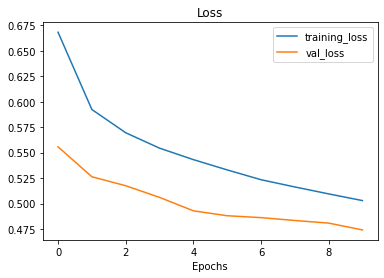

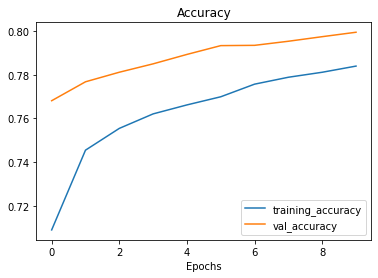

In [ ]:
plot_loss_curves(history)

## Model Evaluation

### Testing our trained model on valid data this predict function we give us the probability

In [ ]:
y_probs = model.predict(valid_dataset)

987/987 [==============================] - 126s 119ms/step


###Converting probability to class labels

In [ ]:
y_preds = tf.argmax(y_probs, axis = 1)

In [ ]:
val_labels[:10]

[1, 2, 0, 0, 2, 0, 1, 1, 1, 1]

In [ ]:
y_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([1, 1, 0, 2, 2, 2, 1, 1, 1, 1])>

###Ploting the Confusion Matrix

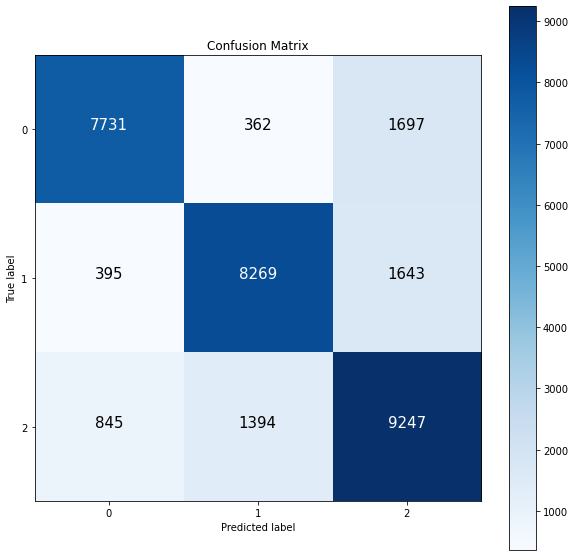

In [ ]:
make_confusion_matrix(val_labels, y_preds)

### Loading best performing model so far

▶ The model which you have seen above is a recently trained model and the accuracy is not the desired one. so i have this best performing trained model which was previously trained on this same neural network architecture

⏰ Remainder : At the time of testing this model, dont forget to load the sentence encoder model as it is from external source so you have to write this this below code where **hub** is alias for tensorflow_hub library to load model in your notebook

In [12]:
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/kaggle_datasets/best_model (1).h5",custom_objects={"KerasLayer": hub.KerasLayer})

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


###Ploting model summary of best performing model

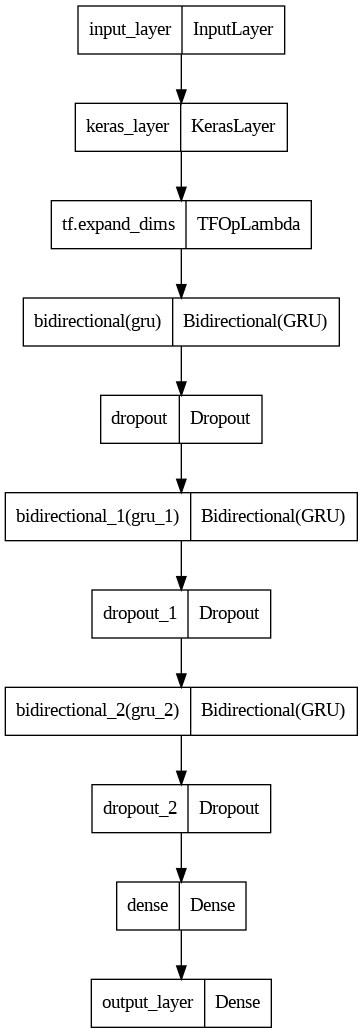

In [13]:
from keras.utils.vis_utils import plot_model
plot_model(loaded_model)

###Model evalution same as above

In [14]:
y_probs = loaded_model.predict(valid_dataset)

987/987 [==============================] - 140s 127ms/step


In [15]:
y_preds = tf.argmax(y_probs, axis = 1)

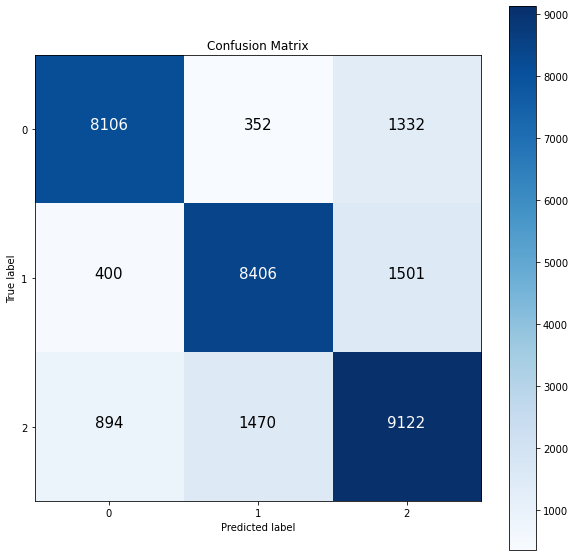

In [16]:
make_confusion_matrix(val_labels, y_preds)

In [17]:
accuracy_score(val_labels, y_preds)

0.8116391729728019

###Loaded model Classification Report

In [18]:
from sklearn.metrics import classification_report
print(classification_report(val_labels, y_preds))

              precision    recall  f1-score   support

           0       0.86      0.83      0.84      9790
           1       0.82      0.82      0.82     10307
           2       0.76      0.79      0.78     11486

    accuracy                           0.81     31583
   macro avg       0.82      0.81      0.81     31583
weighted avg       0.81      0.81      0.81     31583



##Realtime Testing on this trained model

> Overview 

In this step we are going to test this model on few realtime hate statements given by poltictians, feel free to test your own sentences on this model

🧭 Disclaimer:

Before you guys proceed further , i would like to apologize you guys in advance because the statements which i m going to use are real hate speechs given by poltictians. im just testing this model on realtime to check performance. So, Please dont judge me 






Statements to be used:






*  Once a muslim will become the pm 50 percent hindus will convert 40 percent will be killed 10 percent will either live in refugee camp or in other countries If you want to avoid this future, then become a man and take up arms.

*   And we have pleged to ourselves if they take one hindu girl, we will snatch at least 100 muslim girls from them.

*  Hitler did very cruel and ugly things. But he was an artist, I love him (for that). He had the power to carry the whole nation, the mob with him. You have to think what magic he had. He was a miracle.... The killing of Jews was wrong. But the good part about Hitler was that he was an artist. He was a daredevil. He had good qualities and bad. I may also have good qualities and bad ones.








  









In [44]:
sentence = "Hitler did very cruel and ugly things. But he was an artist, I love him (for that). He had the power to carry the whole nation, the mob with him. You have to think what magic he had. He was a miracle.... The killing of Jews was wrong. But the good part about Hitler was that he was an artist. He was a daredevil. He had good qualities and bad. I may also have good qualities and bad ones."

###Defining the if statements for real prediction

In [45]:
pred_prob = loaded_model.predict([sentence])# getting probabilty of a given sentence
pred_label = tf.argmax(pred_prob, axis = 1)# converting probability to labels

#defining simple if statements

if pred_label==1:
  print("Potentially Risky") 
elif pred_label== 2:
  print("Risky")
else:
  print("Non-Risky")
print(f"Text:\n{sentence}")

1/1 [==============================] - 0s 120ms/step
Risky
Text:
Hitler did very cruel and ugly things. But he was an artist, I love him (for that). He had the power to carry the whole nation, the mob with him. You have to think what magic he had. He was a miracle.... The killing of Jews was wrong. But the good part about Hitler was that he was an artist. He was a daredevil. He had good qualities and bad. I may also have good qualities and bad ones.
